In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
# Right after importing seaborn (could also use 'whitegrid')
sns.set_theme(style='darkgrid', context='talk')

import warnings
warnings.filterwarnings('ignore')

from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error
from numpy import sqrt
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
data=pd.read_csv('data_cleaned.csv', parse_dates=['date'], index_col=0)
data.head()

,order_id,date,item_code,quantity,unit_price_vat_excl,unit_cogs,net_revenue,gross_revenue,margin_revenue,country,item_name,style,name,group0,group1,category
0,1900052301.000,2019-06-04,ZB00025746,1,9.412,0.000,9.412,0.000,9.412,Romania,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
1,1900100835.000,2019-07-15,ZB00025746,1,8.649,5.393,8.649,5.393,3.255,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
2,1900106577.000,2019-07-24,ZB00025746,1,8.649,5.459,8.649,5.459,3.190,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
3,1900111398.000,2019-08-01,ZB00025746,1,8.649,5.440,8.649,5.440,3.209,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
4,1900052301.000,2019-06-04,ZB00022010,1,12.785,4.088,12.785,4.088,8.697,Romania,NK MERC LT GRD,sp2120-703,Nike,Equipment,Guards,football


In [3]:
data=data[data['country']=='Czech Republic']
data.shape

(498832, 16)

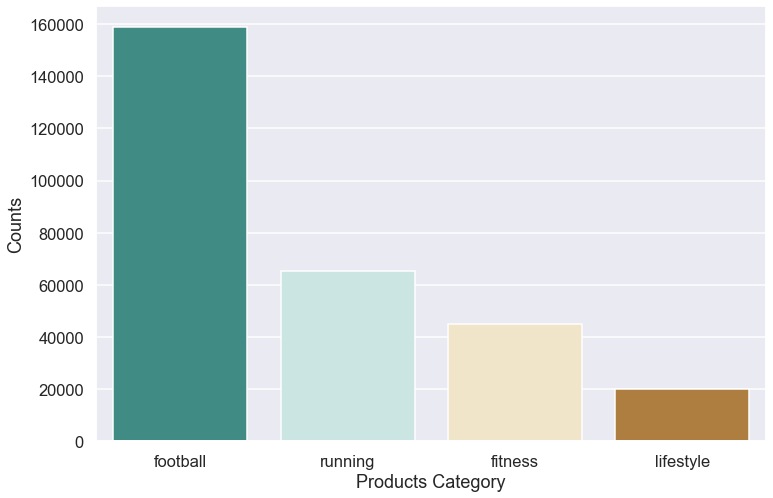

In [6]:
products_category=data['category'].value_counts()
plt.figure(figsize=(12, 8))
sns.barplot(products_category.index, products_category.values, palette='BrBG_r')
plt.ylabel('Counts')
plt.xlabel('Products Category')
plt.show()

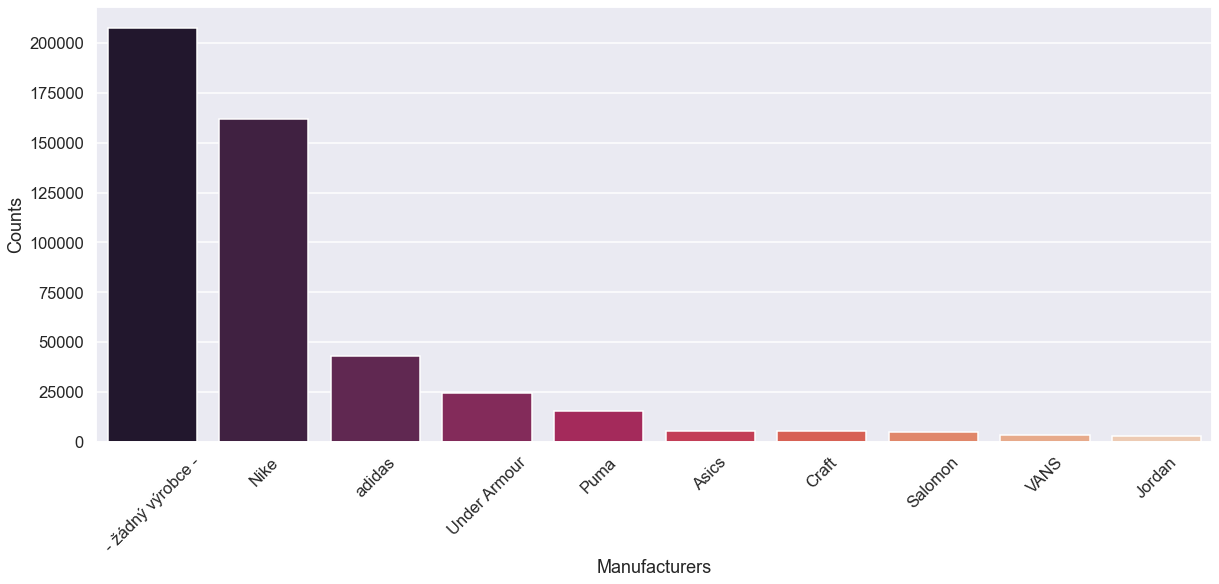

In [4]:
# Let's see the number of orders based on products manufacturers
product_manufacturers=data['name'].value_counts().head(10)
plt.figure(figsize=(20, 8))
sns.barplot(product_manufacturers.index, product_manufacturers.values, palette='rocket')
plt.ylabel('Counts')
plt.xlabel('Manufacturers')
plt.xticks(rotation=45)
plt.show()

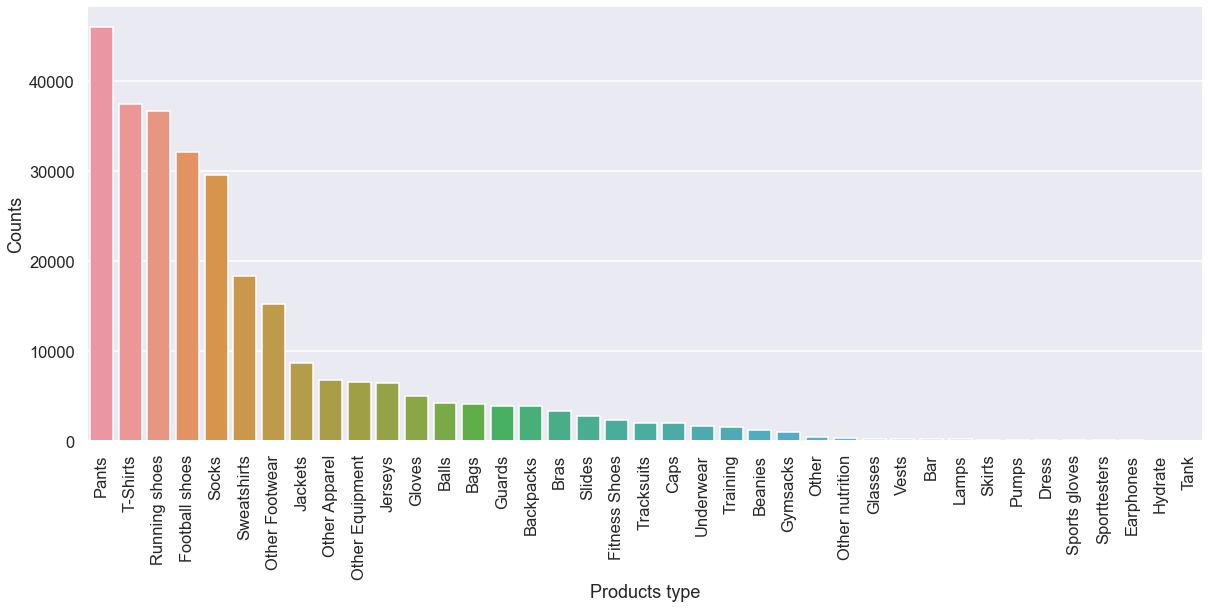

In [5]:
# Let's see which group of products are usually purchased by customers from top4sport
products=data['group1'].value_counts()
plt.figure(figsize=(20, 8))
sns.barplot(products.index, products.values)
plt.ylabel('Counts')
plt.xlabel('Products type')
plt.xticks(rotation=90)
plt.show()

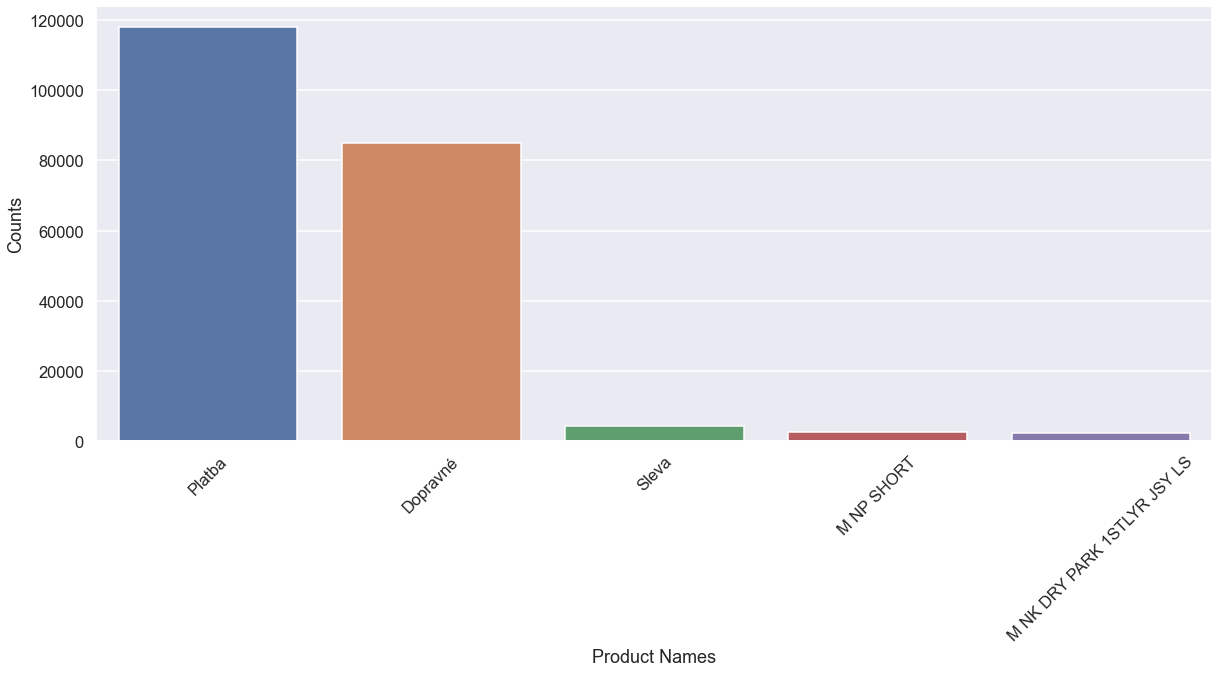

In [23]:
# Let's see what are the top 5 source of revenue based on product names for top4sport in Czech Republic.
items_sales=data['item_name'].value_counts().head(5)
plt.figure(figsize=(20, 8))
sns.barplot(items_sales.index, items_sales.values)
plt.ylabel('Counts')
plt.xlabel('Product Names')
plt.xticks(rotation=45)
plt.show()

In [91]:
# Let's see from which manufacturer the top4sport makes more money. 
revenues=data[['name', 'net_revenue']]
revenues=revenues.groupby(['name'])['net_revenue'].sum().reset_index()
revenues=revenues.sort_values(by='net_revenue', ascending=False).head(10)



,name,net_revenue
55,Nike,6.739762e+06
91,adidas,1.910944e+06
87,Under Armour,7.143900e+05
64,Puma,5.597316e+05
4,Asics,4.048823e+05
71,Salomon,3.637123e+05
0,- žádný výrobce -,2.512478e+05
35,INOV-8,1.607357e+05
41,Jordan,1.345848e+05
16,Craft,1.342200e+05


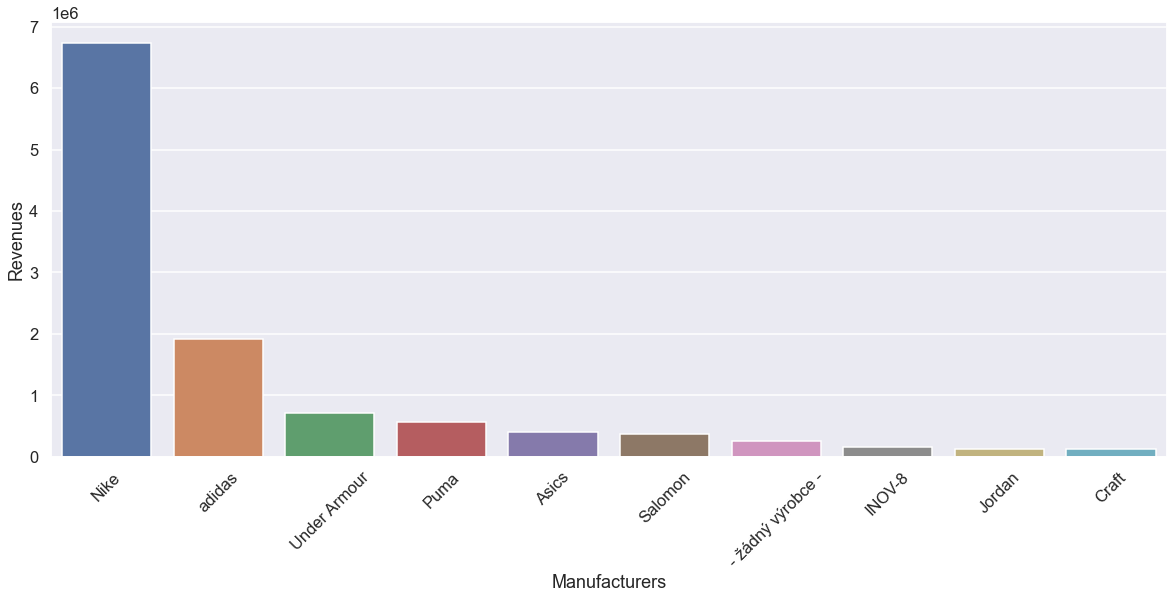

In [112]:
plt.figure(figsize=(20, 8))
sns.barplot(x=revenues.name, y=revenues.net_revenue)
plt.ylabel('Revenues')
plt.xlabel('Manufacturers')
plt.xticks(rotation=45)
plt.show()

In [8]:
def select_series(data, time_period='day', revenue='net'):
    time_periods = {
        'day': 'D',
        'week': 'W',
        'month': 'M'}
    
    revenue_cat = {
        'net':'net_revenue',
        'gross':'gross_revenue',
        'margin':'margin_revenue'}
    
    data = data.set_index('date')
    data = data[revenue_cat[revenue]].resample(time_periods[time_period]).sum()
    data = pd.DataFrame(data).reset_index()
    return data

In [9]:
daily_sales=select_series(data)
daily_sales.columns=['ds', 'y']
daily_sales.ds=pd.to_datetime(daily_sales['ds'])
daily_sales.sort_values('ds')
daily_sales.head()

,ds,y
0,2019-06-01,2699.499461
1,2019-06-02,139.279069
2,2019-06-03,1101.867053
3,2019-06-04,25417.299935
4,2019-06-05,48902.704548


In [10]:
daily_sales.to_csv(r'czech_dailysales.csv')

In [14]:
sales=pd.read_csv('czech_dailysales.csv')
sales=sales.drop(['Unnamed: 0'], axis=1)
sales.columns=['date', 'sales']
sales.head()

,date,sales
0,2019-06-01,2699.499462
1,2019-06-02,139.279069
2,2019-06-03,1101.867053
3,2019-06-04,25417.299935
4,2019-06-05,48902.704548


In [18]:
# convert date column to datatime object
sales['date'] = pd.to_datetime(sales['date'], format='%Y-%m-%d') 


# Create Date-related Features for EDA and modeling
sales['year'] = sales['date'].dt.year
sales['month'] = sales['date'].dt.month
sales['day'] = sales['date'].dt.day
sales['weekday'] = sales['date'].dt.weekday
sales['weekday'] = np.where(sales.weekday == 0, 7, sales.weekday)
sales.head()

,date,sales,year,month,day,weekday
0,2019-06-01,2699.499462,2019,6,1,5
1,2019-06-02,139.279069,2019,6,2,6
2,2019-06-03,1101.867053,2019,6,3,7
3,2019-06-04,25417.299935,2019,6,4,1
4,2019-06-05,48902.704548,2019,6,5,2


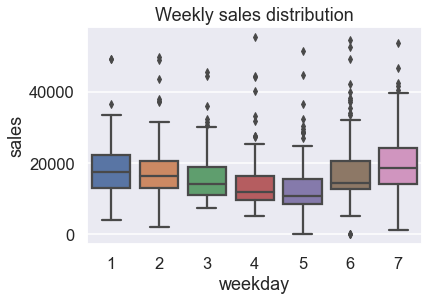

In [20]:
#let's find out the usual sales during a week

plot = sns.boxplot(x='weekday', y='sales', data=sales)
_ = plot.set(title='Weekly sales distribution')

#### It seems like the sales peak is on Sundays (day 7), and it is followed by Mondays.

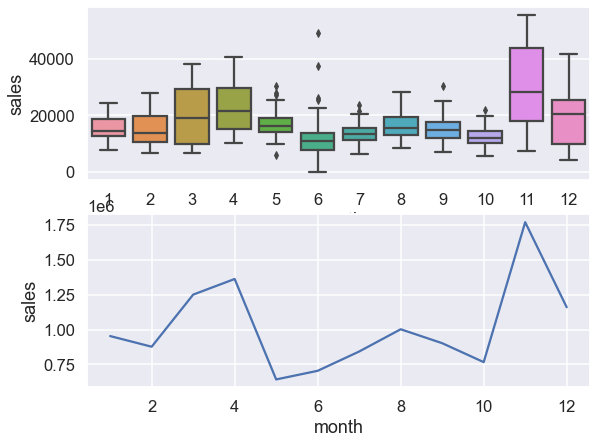

In [22]:
# let's see how monthly sales looks like in a year. 
monthly_agg = sales.groupby('month')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sns.boxplot(x='month', y='sales', data=sales, ax=axs[0])
_ = sns.lineplot(x='month', y='sales', data=monthly_agg, ax=axs[1])

In [7]:

train_df=daily_sales[:int(daily_sales.shape[0]*0.75)]

test_df=daily_sales[int(daily_sales.shape[0]*0.75):]
print(train_df.shape)
print(test_df.shape)

(530, 2)
(177, 2)


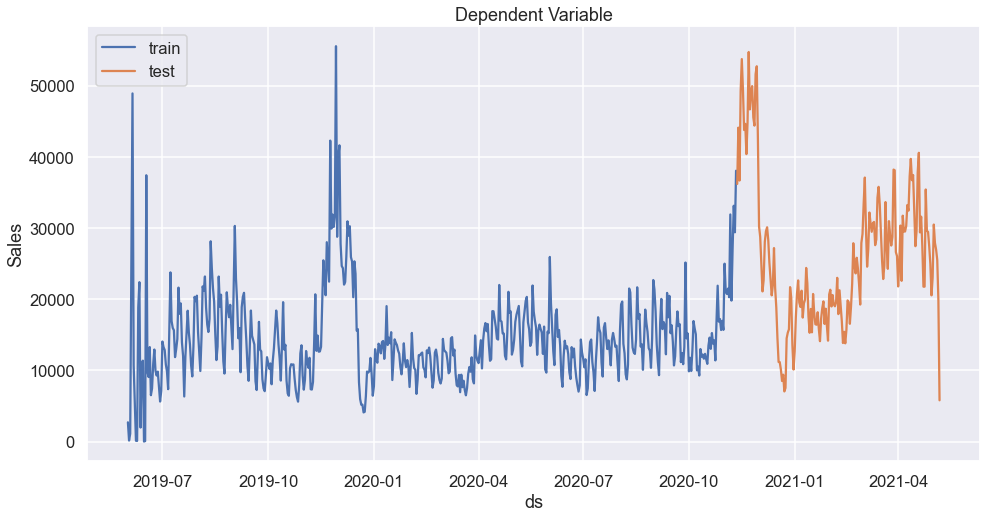

In [8]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x='ds', y='y', label='train', data=train_df, ax=ax)
sns.lineplot(x='ds', y='y', label='test', data=test_df, ax=ax)

ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='Sales');

In [9]:
#training the model on training set
model=Prophet(weekly_seasonality=True, daily_seasonality=False, n_changepoints=3)
model.add_seasonality(name='monthly', period=30, fourier_order=1)
model.fit(train_df)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [10]:
future=model.make_future_dataframe(periods=207, freq='D')
forecast=model.predict(future)

In [11]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-06-01,14357.533917,1815.893795,17564.956223,14357.533917,14357.533917,-4588.483542,-4588.483542,-4588.483542,-654.941557,-654.941557,-654.941557,-3933.541985,-3933.541985,-3933.541985,0.0,0.0,0.0,9769.050374
1,2019-06-02,14356.609891,6446.241753,21606.819668,14356.609891,14356.609891,-431.551279,-431.551279,-431.551279,-490.619732,-490.619732,-490.619732,59.068452,59.068452,59.068452,0.0,0.0,0.0,13925.058612
2,2019-06-03,14355.685865,9902.131077,25232.867207,14355.685865,14355.685865,3139.670469,3139.670469,3139.670469,-304.855469,-304.855469,-304.855469,3444.525938,3444.525938,3444.525938,0.0,0.0,0.0,17495.356334
3,2019-06-04,14354.761840,8533.908030,24052.259913,14354.761840,14354.761840,1794.879151,1794.879151,1794.879151,-105.767560,-105.767560,-105.767560,1900.646712,1900.646712,1900.646712,0.0,0.0,0.0,16149.640991
4,2019-06-05,14353.837814,8212.490044,23528.585867,14353.837814,14353.837814,1528.150898,1528.150898,1528.150898,97.942899,97.942899,97.942899,1430.208000,1430.208000,1430.208000,0.0,0.0,0.0,15881.988712


In [12]:
# We want to look at yhat, yhat_lower, and yhat_upper only. 
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-06-01,9769.050374,1815.893795,17564.956223
1,2019-06-02,13925.058612,6446.241753,21606.819668
2,2019-06-03,17495.356334,9902.131077,25232.867207
3,2019-06-04,16149.640991,8533.908030,24052.259913
4,2019-06-05,15881.988712,8212.490044,23528.585867


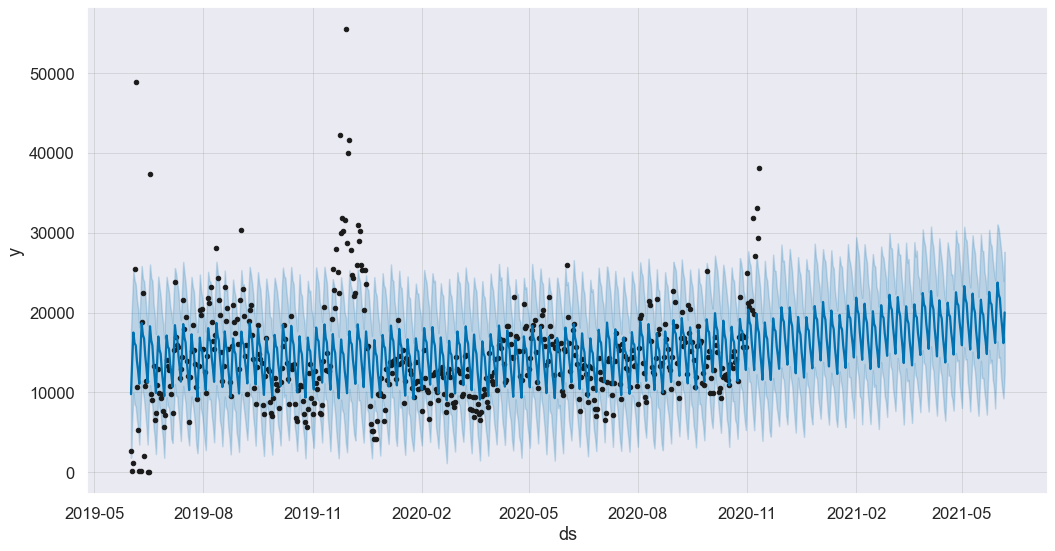

In [13]:
#ploting the forecast
f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)

fig=model.plot(forecast, ax=ax)
plt.show()

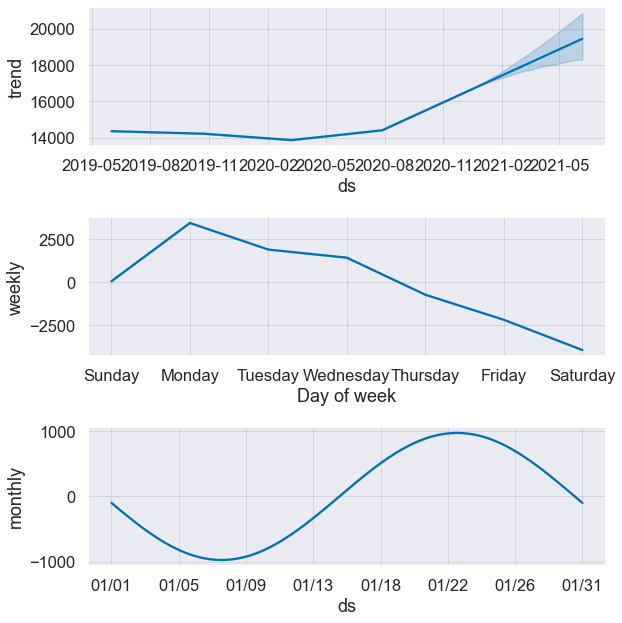

In [14]:
# ploting model components
model.plot_components(forecast)
plt.show()

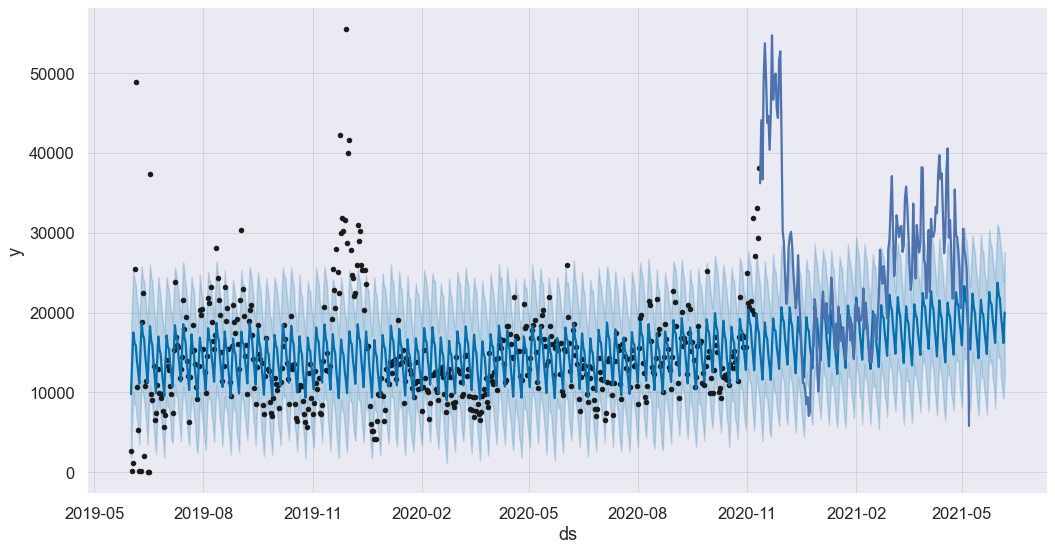

In [15]:
 # comparing Forecast to Actual

f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)


fig=model.plot(forecast, ax=ax)
ax.plot(test_df.ds, test_df.y)



Text(0.5, 1.0, 'One Month Forecast Vs Actual, March 1 to 30, 2021')

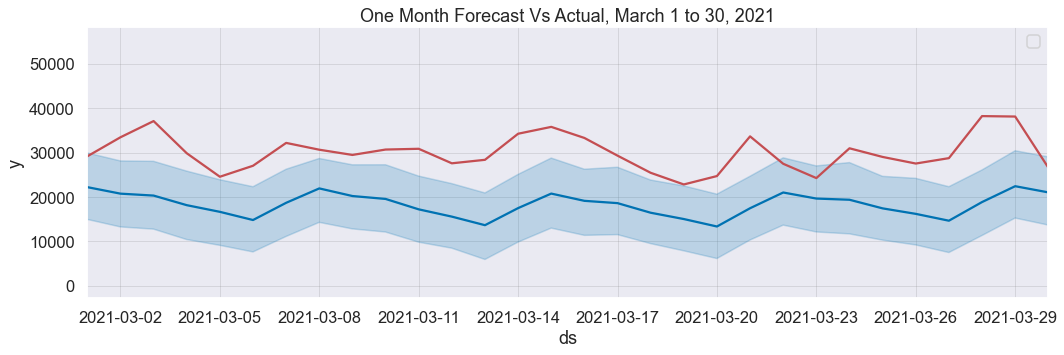

In [16]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-03-01', upper='2021-03-30')
plt.legend()
plt.title('One Month Forecast Vs Actual, March 1 to 30, 2021')



Text(0.5, 1.0, 'One month Forecast Vs Actual, April 07 to May 6 , 2021')

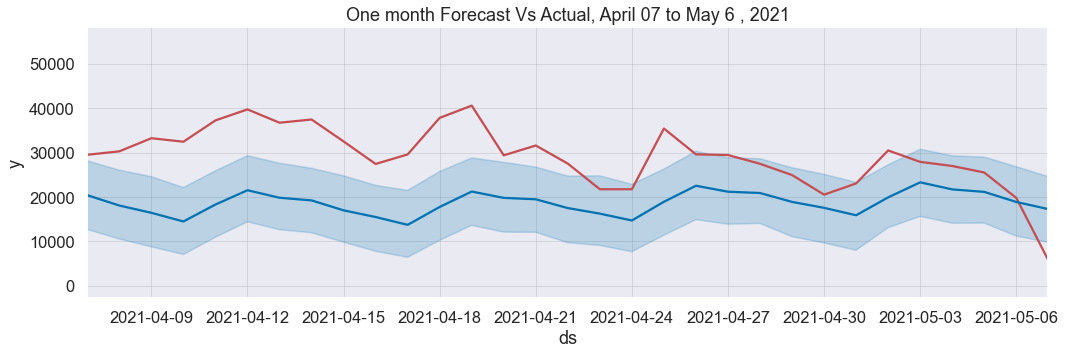

In [17]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-04-07', upper='2021-05-07')

plt.title('One month Forecast Vs Actual, April 07 to May 6 , 2021')

Text(0.5, 1.0, 'One month Forecast, May 07 to June 6, 2021')

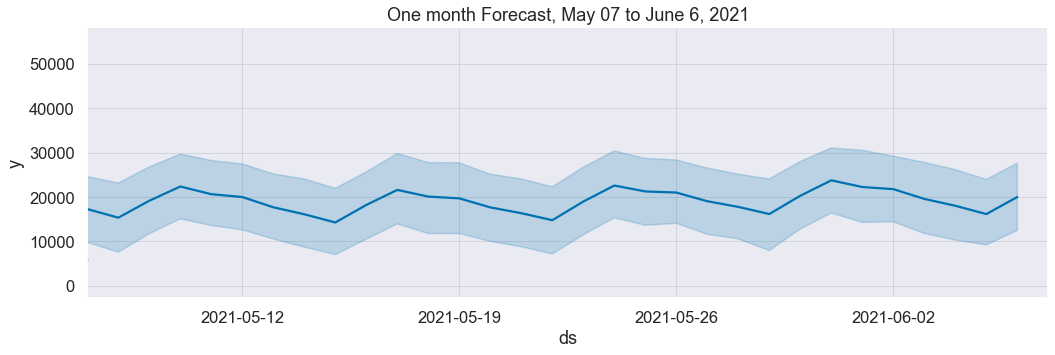

In [18]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-05-07', upper='2021-06-07')

plt.title('One month Forecast, May 07 to June 6, 2021')

Text(0.5, 1.0, 'One week Forecast Vs Actual, March 19 to 25, 2021')

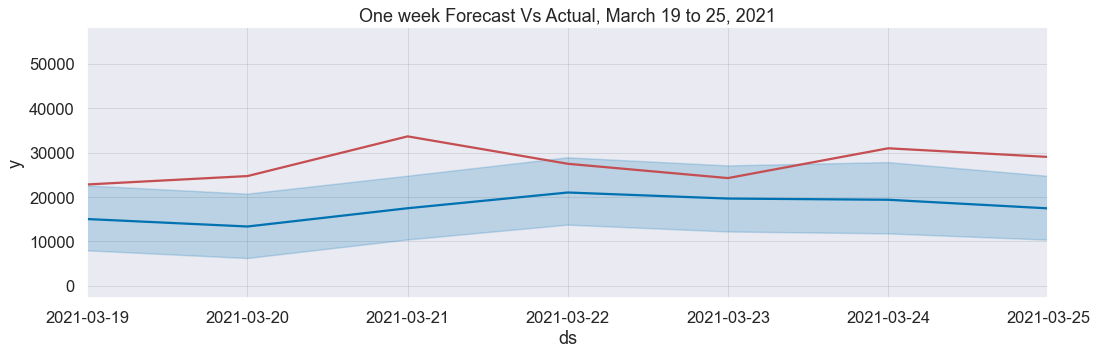

In [19]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-03-19', upper='2021-03-25')

plt.title('One week Forecast Vs Actual, March 19 to 25, 2021')


In [20]:
# Means Squared Error and RSME
predictions=forecast.yhat[-177:]
mse=mean_squared_error(test_df.y, predictions)
rmse=sqrt(mean_squared_error(test_df.y, predictions))
print('MSE: ', mse)
print('RMSE: ', rmse)

#Mean absolute percentage error (mape)

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Cross Validation
df_cv=cross_validation(model, horizon='30 days', initial='90', period='30 days')

mape=mean_absolute_percentage_error(df_cv.y, df_cv.yhat)
print('MAPE: ', mape)

# https://www.kaggle.com/robikscube/time-series-forecasting-with-prophet

INFO:fbprophet:Making 17 forecasts with cutoffs between 2019-06-20 00:00:00 and 2020-10-12 00:00:00


MSE:  169314178.51650983
RMSE:  13012.078178235397



MAPE:  47.40999954242693


In [21]:
df_cv.head()


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-06-21,9102.119662,-4601.614380,21790.063299,6510.520546,2019-06-20
1,2019-06-22,3143.088538,-10177.058662,15663.677431,7452.475953,2019-06-20
2,2019-06-23,3499.971446,-9442.189426,16006.383539,10879.955792,2019-06-20
3,2019-06-24,23974.302231,10824.912421,37498.871496,12924.456173,2019-06-20
4,2019-06-25,25495.563328,13112.657060,39650.947103,9948.256175,2019-06-20


In [22]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
505,2020-11-07,10227.249898,2609.377815,17410.249925,19800.453825,2020-10-12
506,2020-11-08,13952.341376,6986.704352,21414.976132,27126.146311,2020-10-12
507,2020-11-09,17256.304745,10158.011510,24380.945820,33121.744871,2020-10-12
508,2020-11-10,15660.386161,7942.343583,22996.442127,29395.578599,2020-10-12
509,2020-11-11,14839.288330,7408.099188,22026.520244,38047.411512,2020-10-12


In [23]:
### Performance Metrics
from fbprophet.diagnostics import performance_metrics
df_perf = performance_metrics(df_cv)
df_perf

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,3.285562e+07,5731.982628,4362.794280,0.375632,0.260460,0.862745
1,4 days,4.511393e+07,6716.690098,4783.148160,0.417889,0.226394,0.843137
2,5 days,5.676503e+07,7534.257097,5083.797865,0.457183,0.200396,0.823529
3,6 days,7.757631e+07,8807.741669,5824.015006,0.576263,0.257443,0.803922
4,7 days,9.964229e+07,9982.098647,6147.510951,0.646351,0.257443,0.803922
5,8 days,1.010162e+08,10050.683318,6402.270016,0.672602,0.323656,0.803922
6,9 days,8.779457e+07,9369.875815,6058.042438,0.574412,0.267316,0.823529
7,10 days,6.237407e+07,7897.725621,5596.857083,0.504778,0.366528,0.823529
8,11 days,6.493059e+07,8057.951677,5535.820637,0.449271,0.265664,0.803922
9,12 days,1.168078e+08,10807.763534,6466.102949,0.455760,0.217258,0.784314


Text(0.5, 1.0, ' Forecast Vs Actual')

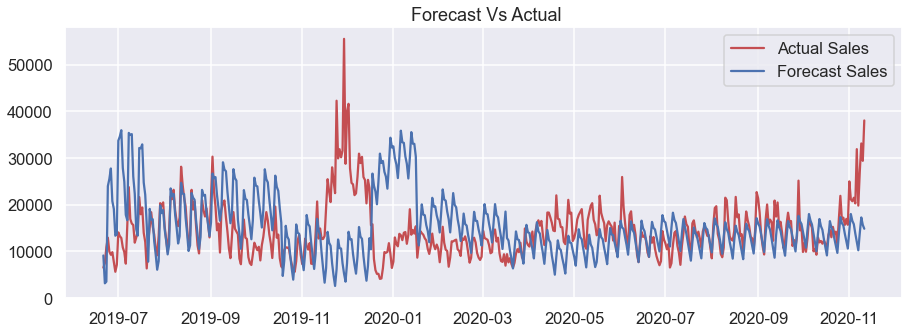

In [25]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(df_cv['ds'], df_cv['y'], color='r', label='Actual Sales')
ax.plot(df_cv['ds'], df_cv['yhat'], color='b', label='Forecast Sales')
plt.legend()



plt.title(' Forecast Vs Actual')

# Hyperparameter tuning

In [26]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 150


In [27]:
import itertools
param_grid = {'seasonality_mode':('multiplicative','additive'),  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
             'n_changepoints' : [3, 6, 9, 12, 15, 18, 21, 24, 25, 30]}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    cutoffs=pd.to_datetime(['2020-03-03','2020-04-28'])
    m = Prophet(**params).fit(train_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

#https://facebook.github.io/prophet/docs/diagnostics.html

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9f9b57d2b0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9f9b5c78e0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9f9e5c80d0>
INFO:fbprophet:Disabling yearly seaso

    seasonality_mode  changepoint_prior_scale  seasonality_prior_scale  \
0     multiplicative                    0.001                     0.01   
1     multiplicative                    0.001                     0.01   
2     multiplicative                    0.001                     0.01   
3     multiplicative                    0.001                     0.01   
4     multiplicative                    0.001                     0.01   
..               ...                      ...                      ...   
315         additive                    0.500                    10.00   
316         additive                    0.500                    10.00   
317         additive                    0.500                    10.00   
318         additive                    0.500                    10.00   
319         additive                    0.500                    10.00   

     n_changepoints          rmse  
0                 3   6776.594470  
1                 6   8041.612714  
2  

In [28]:

tuning_results.sort_values(by=['rmse'])

,seasonality_mode,changepoint_prior_scale,seasonality_prior_scale,n_changepoints,rmse
284,additive,0.500,0.01,15,2201.276122
282,additive,0.500,0.01,9,2213.192028
283,additive,0.500,0.01,12,2232.538934
289,additive,0.500,0.01,30,2235.997352
133,multiplicative,0.500,0.10,12,2245.645319
...,...,...,...,...,...
34,multiplicative,0.001,10.00,15,13010.653280
15,multiplicative,0.001,0.10,18,13170.044944
175,additive,0.001,0.10,18,13268.710834
195,additive,0.001,10.00,18,13316.772939


In [40]:
final_model=Prophet(growth='linear', daily_seasonality=True, seasonality_mode='additive', seasonality_prior_scale=0.01, changepoint_prior_scale=0.500, n_changepoints=15)
final_model.add_seasonality(name='monthly', period=30, fourier_order=1)
final_model.fit(train_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [41]:
future=final_model.make_future_dataframe(periods=test_df.shape[0]+30, freq='D')
final_forecast=final_model.predict(future)

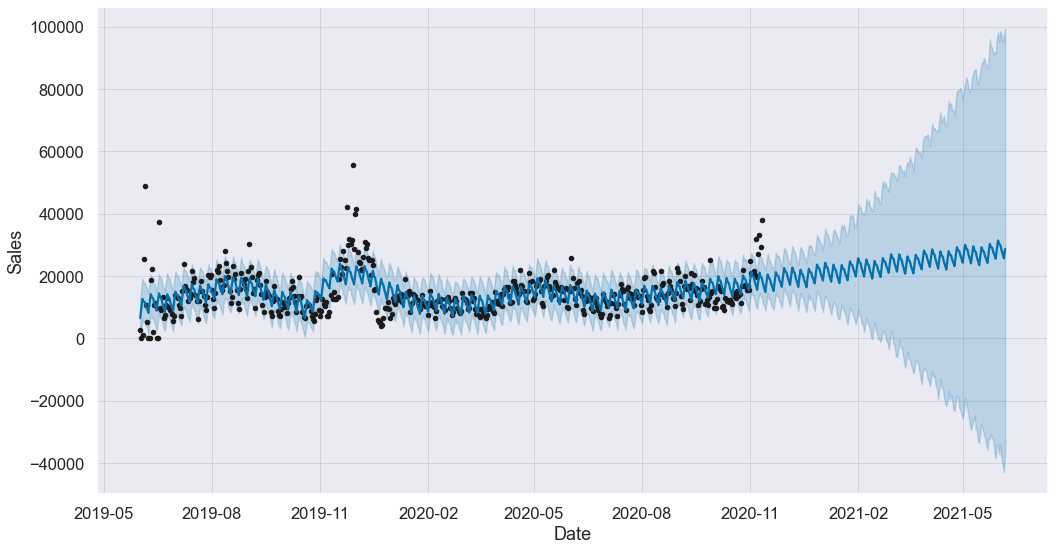

In [42]:
f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)

fig=final_model.plot(final_forecast, ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.show()

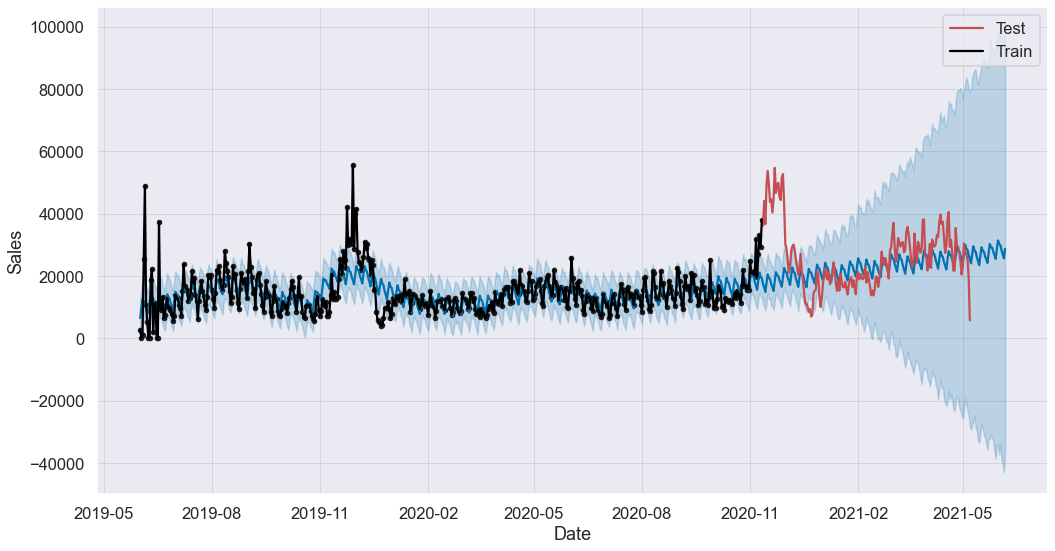

In [43]:
f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)


final_model.plot(final_forecast, ax=ax)
ax.plot(test_df.ds, test_df.y, color='r', label='Test')
ax.plot(train_df.ds, train_df.y, color='black', label='Train')
plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.show()

Text(0.5, 1.0, 'Forecast VS Actual Daily Sales')

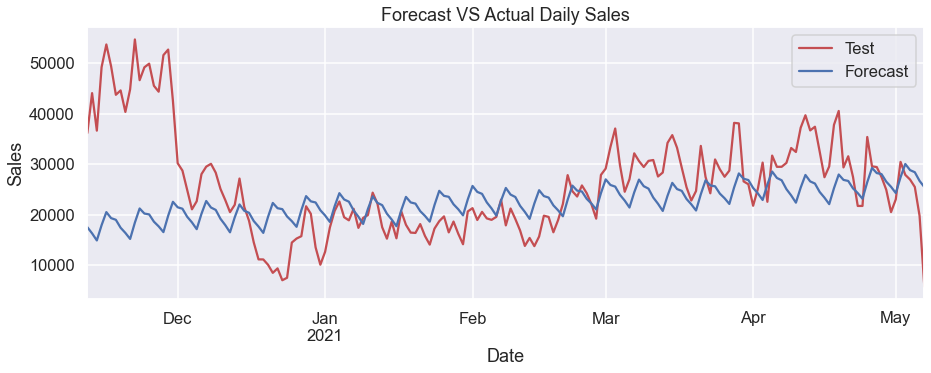

In [44]:
# Plot the forecast with the actuals
x_test_forecast=final_model.predict(test_df)

f, ax = plt.subplots(figsize=(14, 5))
f.set_figheight(5)
f.set_figwidth(15)
test_df.plot(x='ds', y='y', color='r', label='Test', ax=ax)
x_test_forecast.plot(x='ds', y='yhat', label='Forecast', ax=ax)
plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.title('Forecast VS Actual Daily Sales')

In [45]:
mape=mean_absolute_percentage_error(test_df.y, x_test_forecast.yhat)
print('MAPE: ', mape)

MAPE:  29.735527300952036


Text(0.5, 1.0, 'One month daily sales Forecast Vs Actual after model improvement, April 07 to May 6 , 2021')

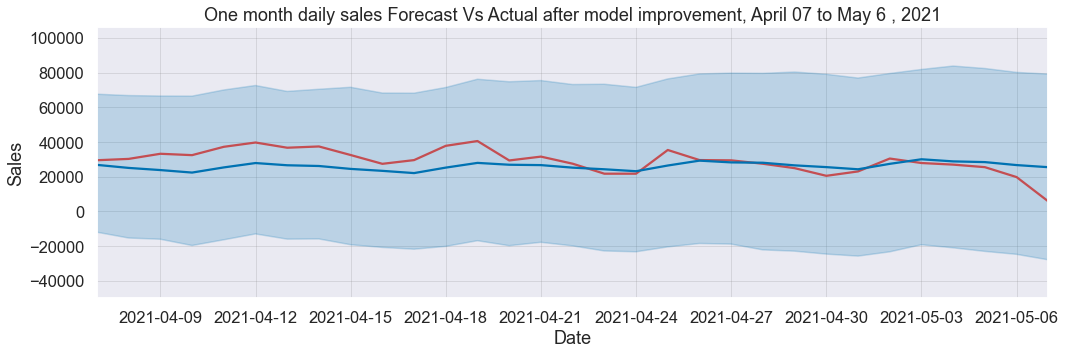

In [46]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = final_model.plot(final_forecast, ax=ax)
ax.set_xbound(lower='2021-04-07', upper='2021-05-07')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.title('One month daily sales Forecast Vs Actual after model improvement, April 07 to May 6 , 2021')

Text(0.5, 1.0, 'One week daily sales Forecast Vs Actual after model improvement, April 07 to May 6 , 2021')

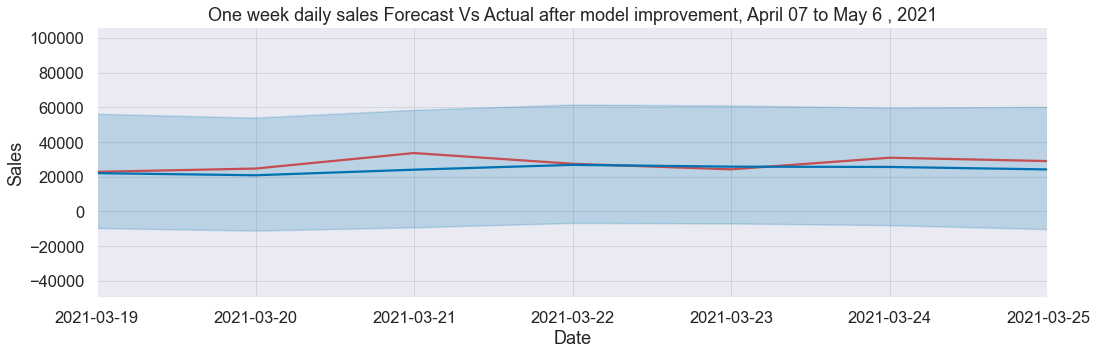

In [47]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = final_model.plot(final_forecast, ax=ax)
ax.set_xbound(lower='2021-03-19', upper='2021-03-25')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.title('One week daily sales Forecast Vs Actual after model improvement, April 07 to May 6 , 2021')

Text(0.5, 1.0, 'One month daily sales Forecast after model improvement, May 07 to June 6, 2021')

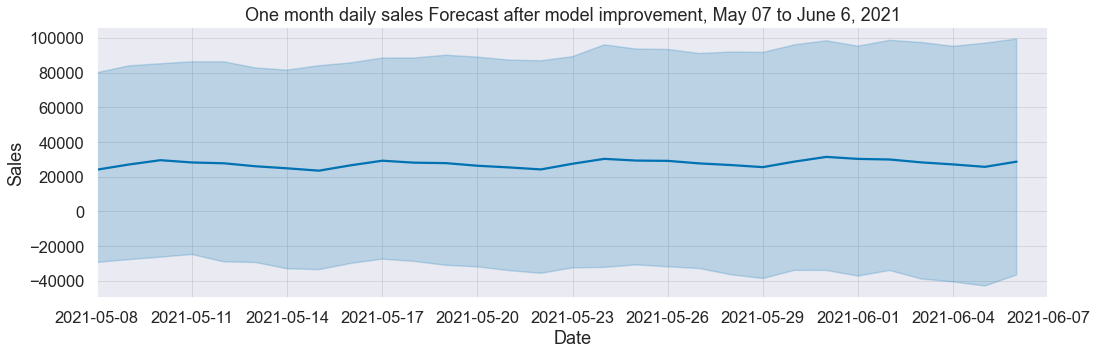

In [48]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = final_model.plot(final_forecast, ax=ax)
ax.set_xbound(lower='2021-05-08', upper='2021-06-07')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.title('One month daily sales Forecast after model improvement, May 07 to June 6, 2021')

In [49]:
forecast_one=forecast[['ds', 'yhat']]
forecast_two=final_forecast[['ds', 'yhat']]
forecast_one.columns=['ds', 'yhat_one']
forecast_two.columns=['ds', 'yhat_two']
forecast_combined=pd.merge(forecast_one, forecast_two, on='ds')
forecast_combined.head()

,ds,yhat_one,yhat_two
0,2019-06-01,9769.050374,6522.255260
1,2019-06-02,13925.058612,9826.349541
2,2019-06-03,17495.356334,12679.214546
3,2019-06-04,16149.640991,11728.465595
4,2019-06-05,15881.988712,11607.396543


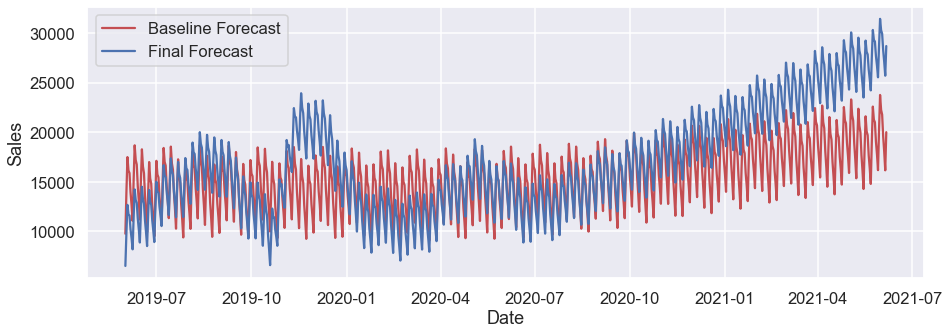

In [50]:
# Comparing the final forecast with the baseline forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(forecast_combined['ds'], forecast_combined['yhat_one'], color='r', label='Baseline Forecast')
ax.plot(forecast_combined['ds'], forecast_combined['yhat_two'], color='b', label='Final Forecast')

plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.show()

